# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based machine learning models in order to find the one that predicts STM transit delays with the best accuracy. The featured models are XGBoost, LightGBM and CatBoost, because they are more suitable for large datasets with mixed data and high cardinality.

## Data Description

`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_direction_North`, `route_direction_South`, `route_direction_West`: Route direction in degrees.<br>
`route_type_Night`, `route_type_HighFrequency` : One-Hot features for types of bus lines<br>
`frequency_frequent`, `frequency_normal`, `frequency_rare`, `frequency_very_frequent`, `frequency_very_rare`: One-Hot features for number of arrivals per hour.<br>
`stop_location_group`: Stop cluster based on coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`trip_phase_middle`, `trip_phase_end`: One-Hot feature for trip progress.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`sch_rel_Scheduled`: One-Hot feature for schedule relationship.<br>
`time_of_day_evening`, `time_of_day_morning`, `time_of_day_night`: One-Hot features for time of day.<br>
`is_peak_hour`: Boolean value indicating if the sheduled arrival time is at peak hour.<br>
`temperature_2m`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity_2m`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure_msl`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed_10m`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction_10m`: Wind direction at 10 meters above ground.<br>

## Imports

In [70]:
from catboost import CatBoostRegressor
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb

In [2]:
# Load data
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (1500000, 28)


## Split the data

In [3]:
# Separate features from target variable
X = df.drop('delay', axis=1)
y = df['delay']

The 3 models can run multiple iterations with a training and validation set. Therefore, a hold-out set will be kept for the final model.

In [4]:
# Train-validation-test split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

del X_temp
del y_temp

**Scaling**

Since only tree-based models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Fit Base Models

All models allow to setup a number of rounds and early stopping. To start, all models will run 100 rounds with an early stopping of 3.

In [5]:
# Create dataframe to track metrics
reg_metrics_df = pd.DataFrame(columns=['model', 'MAE', 'RMSE', 'R²'])

In [6]:
def add_reg_metrics(reg_metrics_df:pd.DataFrame, y_pred:pd.Series, y_true:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)
	r2 = r2_score(y_true, y_pred)

	reg_metrics_df.loc[len(reg_metrics_df)] = [model_name, mae, rmse, r2]
	return reg_metrics_df

### XGBoost

In [7]:
# Create regression matrices
xg_train_data = xgb.DMatrix(X_train, y_train, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val, y_val, enable_categorical=False)
xg_test_data = xgb.DMatrix(X_test, y_test, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]
xg_test_set = [(xg_train_data, 'train'), (xg_test_data, 'test')]

In [8]:
# Train model
xg_reg_base = xgb.train(
  params= {'objective': 'reg:squarederror', 'tree_method': 'hist'},
  dtrain=xg_train_data,
  num_boost_round=100,
  evals=xg_eval_set,
  verbose_eval=10,
  early_stopping_rounds=3
)

[0]	train-rmse:156.42653	validation-rmse:155.68270
[10]	train-rmse:147.99762	validation-rmse:147.96570
[20]	train-rmse:145.45403	validation-rmse:145.73631
[30]	train-rmse:144.09065	validation-rmse:144.56608
[40]	train-rmse:142.68263	validation-rmse:143.41843
[50]	train-rmse:141.60237	validation-rmse:142.44218
[60]	train-rmse:140.47872	validation-rmse:141.56257
[70]	train-rmse:139.60400	validation-rmse:140.91991
[80]	train-rmse:138.76441	validation-rmse:140.30461
[90]	train-rmse:137.93098	validation-rmse:139.61391
[99]	train-rmse:137.45244	validation-rmse:139.21868


In [9]:
# Evaluate model
y_pred = xg_reg_base.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363


**MAE**<br>
On average, the predictions are off by 70 seconds, which is reasonable.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 24.64% of the variance, which is not good but understandable because of how random transit delays can be (bad weather, vehicle breakdown, accidents, etc.)

### LightGBM

In [ ]:
# Create regression datasets
lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)
lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

In [11]:
# Train model
lgb_reg_base = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': -1
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=3)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 27
[LightGBM] [Info] Start training from score 52.317412
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 145.46


In [12]:
# Evaluate model
y_pred = lgb_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363
1,lgb_reg_base,73.040732,145.460156,0.177274


The LightGBM model performs worse than XGBoost, especially in terms of R-squared.

### CatBoost

In [13]:
# Fit model
cat_reg_base = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=10
)

cat_reg_base.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=3)

0:	learn: 160.3585442	test: 159.5918254	best: 159.5918254 (0)	total: 206ms	remaining: 20.4s
10:	learn: 155.0768996	test: 154.2913411	best: 154.2913411 (10)	total: 1.71s	remaining: 13.9s
20:	learn: 152.5763794	test: 151.8497456	best: 151.8497456 (20)	total: 3.12s	remaining: 11.7s
30:	learn: 151.2752278	test: 150.6028222	best: 150.6028222 (30)	total: 4.55s	remaining: 10.1s
40:	learn: 150.1517136	test: 149.5714748	best: 149.5714748 (40)	total: 6.09s	remaining: 8.76s
50:	learn: 149.1911766	test: 148.7022087	best: 148.7022087 (50)	total: 7.7s	remaining: 7.39s
60:	learn: 148.4225032	test: 147.9868119	best: 147.9868119 (60)	total: 9.7s	remaining: 6.2s
70:	learn: 147.7059713	test: 147.3686224	best: 147.3686224 (70)	total: 11.7s	remaining: 4.78s
80:	learn: 147.1302739	test: 146.8505613	best: 146.8505613 (80)	total: 13.4s	remaining: 3.14s
90:	learn: 146.6290587	test: 146.4138912	best: 146.4138912 (90)	total: 15.1s	remaining: 1.49s
99:	learn: 146.2851953	test: 146.1372900	best: 146.1372900 (99)	t

In [14]:
# Evaluate model
y_pred = cat_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363
1,lgb_reg_base,73.040732,145.460156,0.177274
2,cat_reg_base,72.926370,146.137290,0.169596


CatBoost performs almost like LightGBM. Without tuning, XGBoost seems to capture a bit more of the underlying patterns than the two other models.

## Hyperparameter Tuning

### XGBoost

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Exception ignored in: <function ResourceTracker.__del__ at 0x110283740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x101cb3740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

In [17]:
# Best model
xg_best_model = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [18]:
# Train best model with more boost rounds
xg_reg_tuned = xgb.train(
  params= {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': xg_best_params['max_depth'],
    'learning_rate': xg_best_params['learning_rate'],
    'subsample': xg_best_params['subsample'],
    'colsample_bytree': xg_best_params['colsample_bytree'],
  },
  dtrain=xg_train_data,
  num_boost_round=10000,
  evals=xg_eval_set,
  verbose_eval=50,
  early_stopping_rounds=50
)

[0]	train-rmse:157.41624	validation-rmse:156.73087
[50]	train-rmse:139.83316	validation-rmse:141.03755
[100]	train-rmse:135.35094	validation-rmse:137.75292
[150]	train-rmse:132.56404	validation-rmse:136.08212
[200]	train-rmse:129.92441	validation-rmse:134.32053
[250]	train-rmse:128.15174	validation-rmse:133.46574
[300]	train-rmse:126.51643	validation-rmse:132.74446
[350]	train-rmse:125.18793	validation-rmse:132.23107
[400]	train-rmse:123.86903	validation-rmse:131.68449
[450]	train-rmse:122.79300	validation-rmse:131.35440
[500]	train-rmse:121.74906	validation-rmse:131.18421
[550]	train-rmse:120.78393	validation-rmse:130.92493
[600]	train-rmse:119.89343	validation-rmse:130.75078
[650]	train-rmse:119.20546	validation-rmse:130.66849
[700]	train-rmse:118.55264	validation-rmse:130.66285
[719]	train-rmse:118.30821	validation-rmse:130.64755


In [19]:
# Evaluate model
y_pred = xg_reg_tuned.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363
1,lgb_reg_base,73.040732,145.460156,0.177274
2,cat_reg_base,72.926370,146.137290,0.169596
3,xg_reg_tuned,65.967823,130.643265,0.336347


There's a significant improvement from the base XGBoost model and it's the best performing model so far.

### LightGBM

In [ ]:
param_dist = {
  'n_estimators': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, 15],
  'num_leaves': [20, 31, 40],
  'min_child_samples': [10, 20, 30],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 450000, number of used features: 27
[LightGBM] [Info] Start training from score 52.173195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [I

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [20, 31, 40],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

Exception ignored in: <function ResourceTracker.__del__ at 0x105697740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1077db740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

In [21]:
# Best model
lgb_best_model = random_search.best_estimator_
lgb_best_params = random_search.best_params_

In [ ]:
# Train model with more boost rounds and early stopping
lgb_reg_tuned = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': lgb_best_params['n_estimators'],
        'learning_rate': lgb_best_params['learning_rate'],
        'max_depth': lgb_best_params['max_depth'],
        'num_leaves': lgb_best_params['num_leaves'],
        'min_child_samples': lgb_best_params['min_child_samples'],
        'subsample': lgb_best_params['subsample'],
        'colsample_bytree': lgb_best_params['colsample_bytree']
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 27
[LightGBM] [Info] Start training from score 52.317412
Training until validation scores don't improve for 50 rounds


Exception ignored in: <function ResourceTracker.__del__ at 0x1026db740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110487740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 130.643


Exception ignored in: <function ResourceTracker.__del__ at 0x110533740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107897740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

In [23]:
# Evaluate model
y_pred = lgb_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363
1,lgb_reg_base,73.040732,145.460156,0.177274
2,cat_reg_base,72.926370,146.137290,0.169596
3,xg_reg_tuned,65.967823,130.643265,0.336347
4,lgb_reg_tuned,66.230064,130.642509,0.336354


The performance is very similar to the previous tuned model. The MAE is slightly worse but the RMSE and the R-sqared are slightly better.

### CatBoost

In [24]:
param_dist = {
  'iterations': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x1082a3740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10b68f740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x128d42d50>,
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'iterations': [100, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [25]:
# Best model
cat_best_model = random_search.best_estimator_
cat_best_params = random_search.best_params_

In [26]:
# Train best model with more iterations
cat_reg_tuned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

0:	learn: 160.3637681	test: 159.5956913	best: 159.5956913 (0)	total: 190ms	remaining: 31m 41s
50:	learn: 149.2597278	test: 148.7782715	best: 148.7782715 (50)	total: 8.07s	remaining: 26m 14s
100:	learn: 146.1416143	test: 146.0190397	best: 146.0190397 (100)	total: 15.8s	remaining: 25m 52s
150:	learn: 144.0703006	test: 144.1929641	best: 144.1929641 (150)	total: 24.2s	remaining: 26m 17s
200:	learn: 142.5725798	test: 142.8586847	best: 142.8586847 (200)	total: 33.7s	remaining: 27m 20s
250:	learn: 141.1753374	test: 141.6829992	best: 141.6829992 (250)	total: 42.9s	remaining: 27m 47s
300:	learn: 139.8888226	test: 140.5985168	best: 140.5985168 (300)	total: 55.9s	remaining: 30m 2s


Exception ignored in: <function ResourceTracker.__del__ at 0x101fcb740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10797b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

350:	learn: 138.8888120	test: 139.7621289	best: 139.7621289 (350)	total: 1m 6s	remaining: 30m 34s
400:	learn: 137.9286092	test: 139.0206861	best: 139.0206861 (400)	total: 1m 15s	remaining: 30m 14s
450:	learn: 137.0318677	test: 138.2843030	best: 138.2843030 (450)	total: 1m 24s	remaining: 29m 56s
500:	learn: 136.2220085	test: 137.6349714	best: 137.6349714 (500)	total: 1m 33s	remaining: 29m 35s
550:	learn: 135.4916209	test: 137.1123517	best: 137.1123517 (550)	total: 1m 42s	remaining: 29m 15s
600:	learn: 134.8218133	test: 136.5774401	best: 136.5774401 (600)	total: 1m 51s	remaining: 29m
650:	learn: 134.2147539	test: 136.1075697	best: 136.1075697 (650)	total: 2m	remaining: 28m 44s
700:	learn: 133.5739383	test: 135.6260586	best: 135.6260586 (700)	total: 2m 8s	remaining: 28m 28s
750:	learn: 132.9431298	test: 135.1768440	best: 135.1768440 (750)	total: 2m 21s	remaining: 28m 59s
800:	learn: 132.3197850	test: 134.7524897	best: 134.7524897 (800)	total: 2m 33s	remaining: 29m 18s
850:	learn: 131.7764

In [27]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,70.187748,139.218684,0.246363
1,lgb_reg_base,73.040732,145.460156,0.177274
2,cat_reg_base,72.926370,146.137290,0.169596
3,xg_reg_tuned,65.967823,130.643265,0.336347
4,lgb_reg_tuned,66.230064,130.642509,0.336354
5,cat_reg_tuned,64.065594,127.522182,0.367677


CatBoost is the best performing model so far. This is the model that will be used for the rest of the analysis.

## Residual Analysis

In [28]:
# Get predictions
best_model = cat_reg_tuned
y_pred = best_model.predict(X_val)

In [32]:
def plot_residuals(y_true, y_pred, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted Delay (seconds)')
	ax1.set_ylabel('Actual Delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

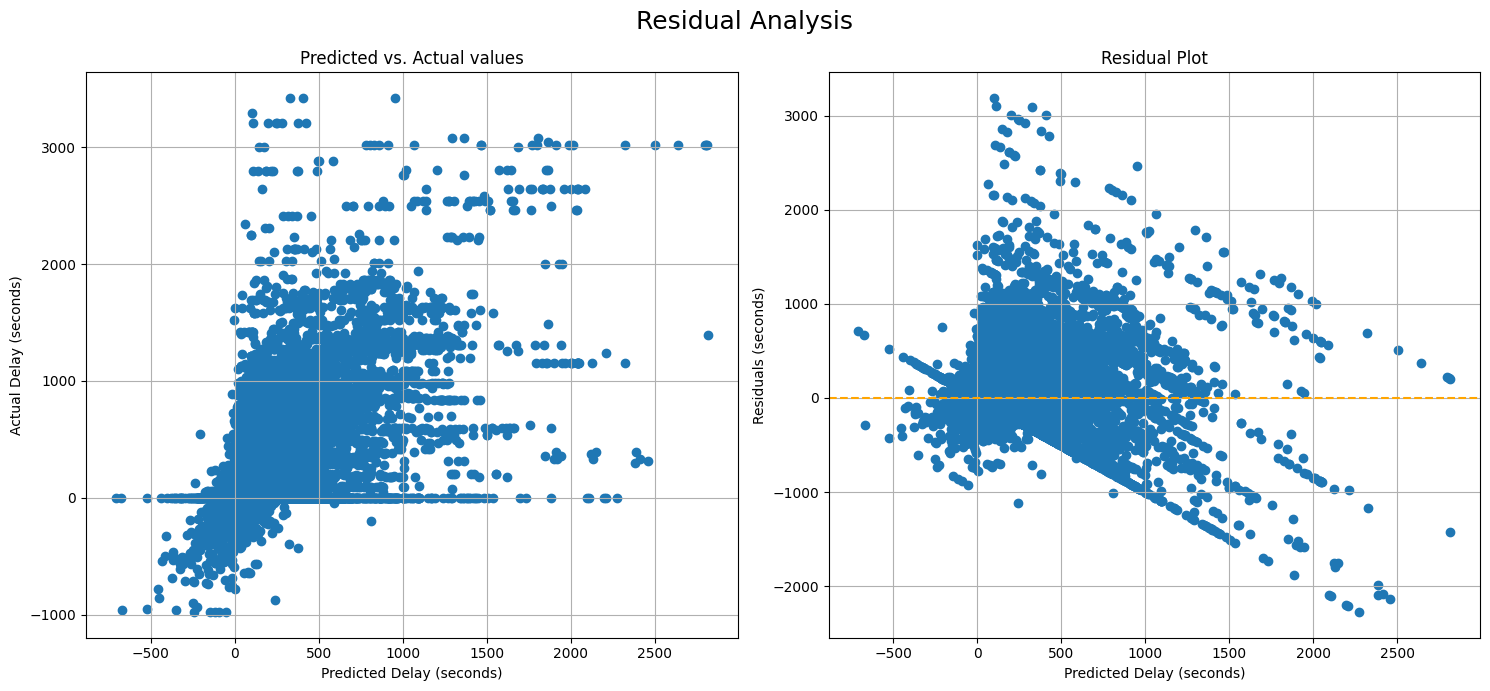

In [33]:
# Plot residuals
plot_residuals(y_val, y_pred, 'cat_reg_tuned')

**Predicted vs. Actual Plot**

There's a dense cluster around 0 for both predicted and actual values, indicating many predictions and centered near 0. However, there is substantial spread both above and below the diagonal line, which suggests underprediction and overprediction. There are clear outliers that are far from the main cluster.


**Residual Plot**

The residuals show a visible diagonal stripe pattern, which indicates a systematic error in prediction. The spread of residuals increases as the predicted delay increases. This is a sign of heteroscedasticity (the variance of errors is not constant across all predictions).

## Feature Importance Plot

In [ ]:
# Get sorted feature importances
feature_importances = best_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
feature_importances

,Feature Id,Importances
0,exp_trip_duration,24.001614
1,hist_avg_delay,15.794278
2,stop_location_group,8.267765
3,temperature_2m,6.966190
4,wind_direction_10m,6.297889
5,wind_speed_10m,6.183005
6,relative_humidity_2m,4.611885
7,route_direction_West,3.836771
8,route_type_HighFrequency,3.634442
9,route_direction_North,2.585473


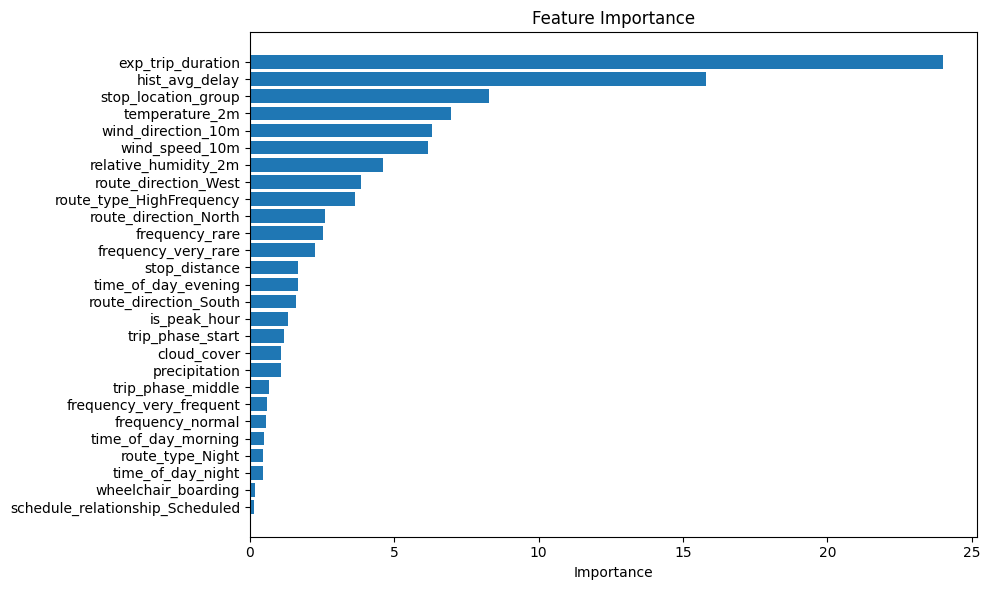

In [34]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig(f'../images/feature_importances.png', bbox_inches='tight')
plt.show()

Interpret plot

## SHAP Plots

In [36]:
# Initialize SHAP
sample_size = 200
X_val_sample = X_val.sample(n=sample_size, random_state=42) # sample validation set to prevent memory overload
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample)

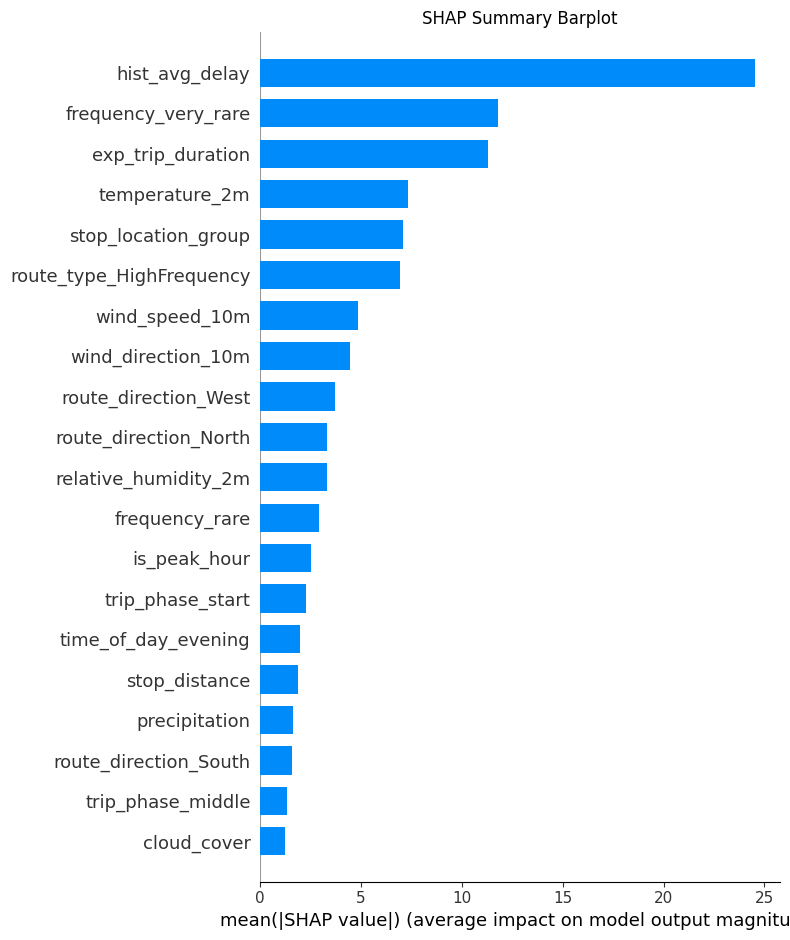

In [39]:
# Summary barplot
shap.summary_plot(shap_values, X_val_sample, plot_type='bar', show=False)
plt.title('SHAP Summary Barplot')
plt.tight_layout()
plt.savefig(f'../images/shap_barplot_cat_reg_tuned.png', bbox_inches='tight')
plt.show()

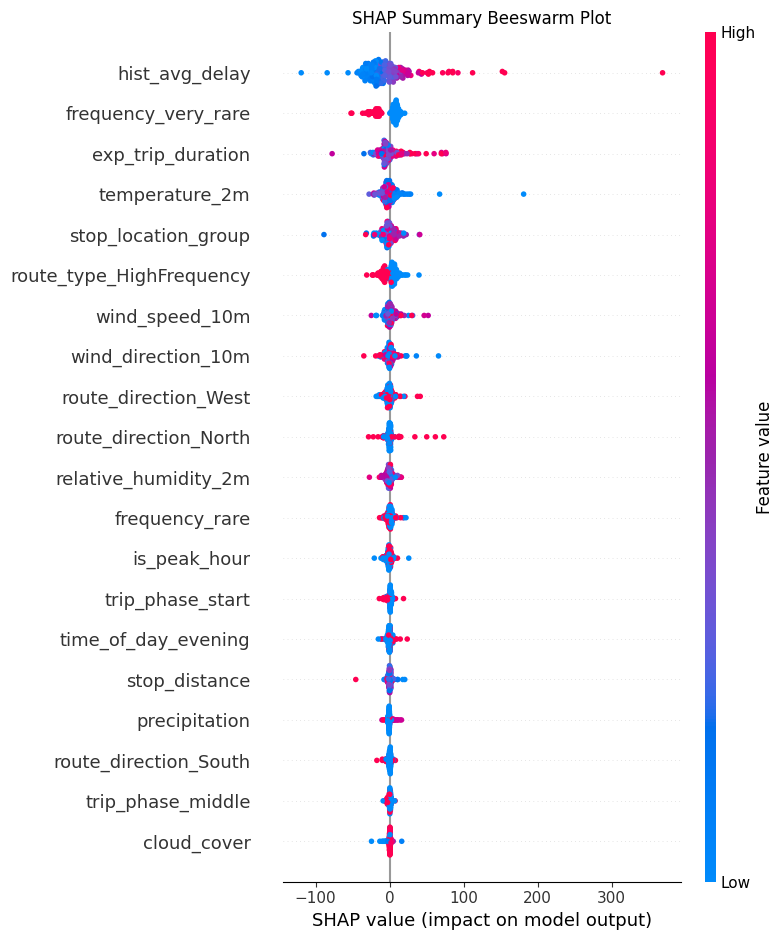

In [40]:
# Summary beeswarm plot
shap.summary_plot(shap_values, X_val_sample, show=False)
plt.title('SHAP Summary Beeswarm Plot')
plt.tight_layout()
plt.savefig(f'../images/shap_beeswarm_plot_cat_reg_tuned.png', bbox_inches='tight')
plt.show()

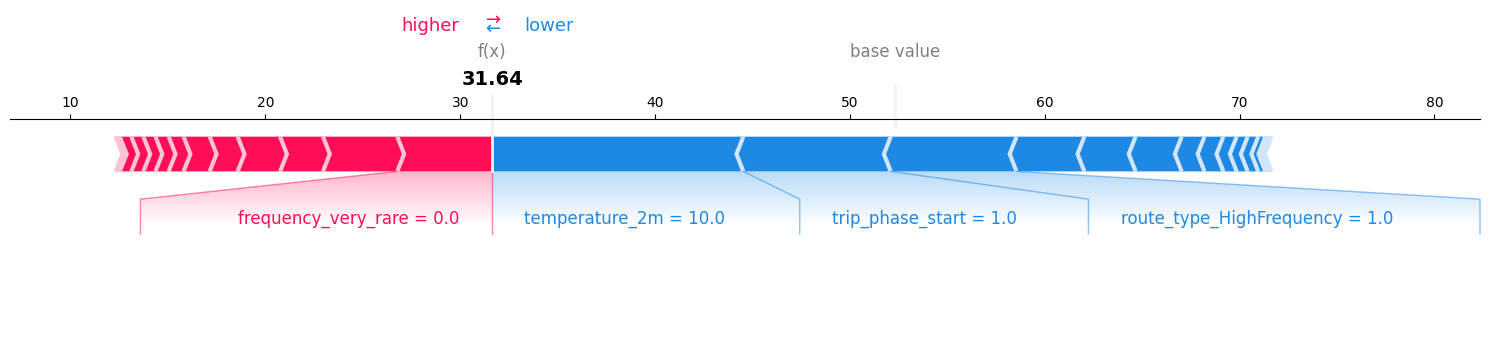

In [69]:
# Force plot a single prediction
index = random.randrange(sample_size)
shap.force_plot(
  	explainer.expected_value,
  	shap_values[index, :],
  	X_val_sample.iloc[index, :],
  	figsize=(15, 4),
	contribution_threshold=0.095,
	matplotlib=True,
  	show=False)
plt.tight_layout()
plt.savefig(f'../images/shap_force_plot_cat_reg_tuned.png', bbox_inches='tight')
plt.show()

## Feature Pruning

In [74]:
# Calculate mean SHAP per feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values('mean_abs_shap', ascending=False)
shap_df

,feature,mean_abs_shap
9,hist_avg_delay,24.548100
23,frequency_very_rare,11.767427
1,exp_trip_duration,11.306828
3,temperature_2m,7.332232
26,stop_location_group,7.077801
15,route_type_HighFrequency,6.942303
7,wind_speed_10m,4.825238
8,wind_direction_10m,4.431524
14,route_direction_West,3.724718
12,route_direction_North,3.317299


In [75]:
# Identify low impact features (below 1)
low_shap_features = shap_df[shap_df['mean_abs_shap'] < 1]

print('One-hot features with low SHAP impact to remove:\n')
print(low_shap_features)

One-hot features with low SHAP impact to remove:

                            feature  mean_abs_shap
18              time_of_day_morning       0.871283
11  schedule_relationship_Scheduled       0.862053
22          frequency_very_frequent       0.766876
19                time_of_day_night       0.482395
0               wheelchair_boarding       0.270069


In [78]:
# Keep best features
features_to_drop = low_shap_features['feature'].tolist()
all_features = X.columns.tolist()

diff = set(all_features) - set(features_to_drop)
best_features = list(diff)

In [ ]:
# Remove columns from input matrices
X_pruned = X[best_features]
X_train_pruned = X_train[best_features]
X_val_pruned = X_val[best_features]
X_test_pruned = X_test[best_features]

## Retrain Model with Best Features

In [ ]:
# Retrain Model
cat_reg_pruned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train_pruned, y_train, eval_set=(X_val_pruned, y_val), early_stopping_rounds=50)

In [ ]:
# Evaluate model
y_pred = cat_reg_pruned.predict(X_val_pruned)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_pruned')
reg_metrics_df

## Retune Parameters

In [ ]:
param_dist = {
  'iterations': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_pruned, y_train)

In [ ]:
# Best model
cat_pruned_best_model = random_search.best_estimator_
cat_pruned_best_params = random_search.best_params_

In [ ]:
# Retrain model
cat_reg_final = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_pruned_best_params['learning_rate'],
    depth=cat_pruned_best_params['depth'],
    l2_leaf_reg=cat_pruned_best_params['l2_leaf_reg'],
    border_count=cat_pruned_best_params['border_count'],
    bagging_temperature=cat_pruned_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_final.fit(X_train_pruned, y_train, eval_set=(X_val_pruned, y_val), early_stopping_rounds=50)

## Final Model

In [ ]:
final_model = cat_reg_final

### Evaluate with Test Set

In [ ]:
# Evaluate model
y_pred = final_model.predict(X_test_pruned)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_final')
reg_metrics_df

In [ ]:
# Plot residuals
plot_residuals(y_test, y_pred, 'cat_reg_final')

### Feature importances

In [ ]:
# Get top 5 most important features
feature_importances = final_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
feature_importances.head()

### Make Prediction

In [ ]:
prediction = final_model.predict(np.array([[0.1, 0.2, 0.3]]))
print(f'Predicted delay: {prediction:.2f}')

### Export Data

In [ ]:
# Save best model
joblib.dump(final_model, 'regression_model.pkl')

## End